<a href="https://colab.research.google.com/github/fares-3adi/FraudDetectionProject/blob/main/CS3IP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Credit Card Fraud Detection Using Machine Learning**

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

## Dataset

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Link to Dataset: https://www.openml.org/search?type=data&status=active&id=42175

Citations:
Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

Dal Pozzolo, Andrea; Caelen, Olivier; Le Borgne, Yann-Ael; Waterschoot, Serge; Bontempi, Gianluca. Learned lessons in credit card fraud detection from a practitioner perspective, Expert systems with applications,41,10,4915-4928,2014, Pergamon

Dal Pozzolo, Andrea; Boracchi, Giacomo; Caelen, Olivier; Alippi, Cesare; Bontempi, Gianluca. Credit card fraud detection: a realistic modeling and a novel learning strategy, IEEE transactions on neural networks and learning systems,29,8,3784-3797,2018,IEEE

Dal Pozzolo, Andrea Adaptive Machine learning for credit card fraud detection ULB MLG PhD thesis (supervised by G. Bontempi)

Carcillo, Fabrizio; Dal Pozzolo, Andrea; Le Borgne, Yann-Ael; Caelen, Olivier; Mazzer, Yannis; Bontempi, Gianluca. Scarff: a scalable framework for streaming credit card fraud detection with Spark, Information fusion,41, 182-194,2018,Elsevier

Carcillo, Fabrizio; Le Borgne, Yann-Ael; Caelen, Olivier; Bontempi, Gianluca. Streaming active learning strategies for real-life credit card fraud detection: assessment and visualization, International Journal of Data Science and Analytics, 5,4,285-300,2018,Springer International Publishing

Bertrand Lebichot, Yann-Ael Le Borgne, Liyun He, Frederic Oble, Gianluca Bontempi Deep-Learning Domain Adaptation Techniques for Credit Cards Fraud Detection, INNSBDDL 2019: Recent Advances in Big Data and Deep Learning, pp 78-88, 2019

Fabrizio Carcillo, Yann-Ael Le Borgne, Olivier Caelen, Frederic Oble, Gianluca Bontempi Combining Unsupervised and Supervised Learning in Credit Card Fraud Detection Information Sciences, 2019.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

# Loading the dataset directly from google drive to avoid
# not fully loading it
import pandas as pd
df = pd.read_csv('/content/drive/My Drive/Colab/CS3IP/creditcard.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


For reference: The column names are Time, V1 ... V28, Amount, and Class

# **Exploratory Data Analysis**

In this section, data analysis will be performed via plots and other means in order to determine a list of Actionables needed for the preprocessing of the dataset before the application of the machine learning models.

## **Histogram**

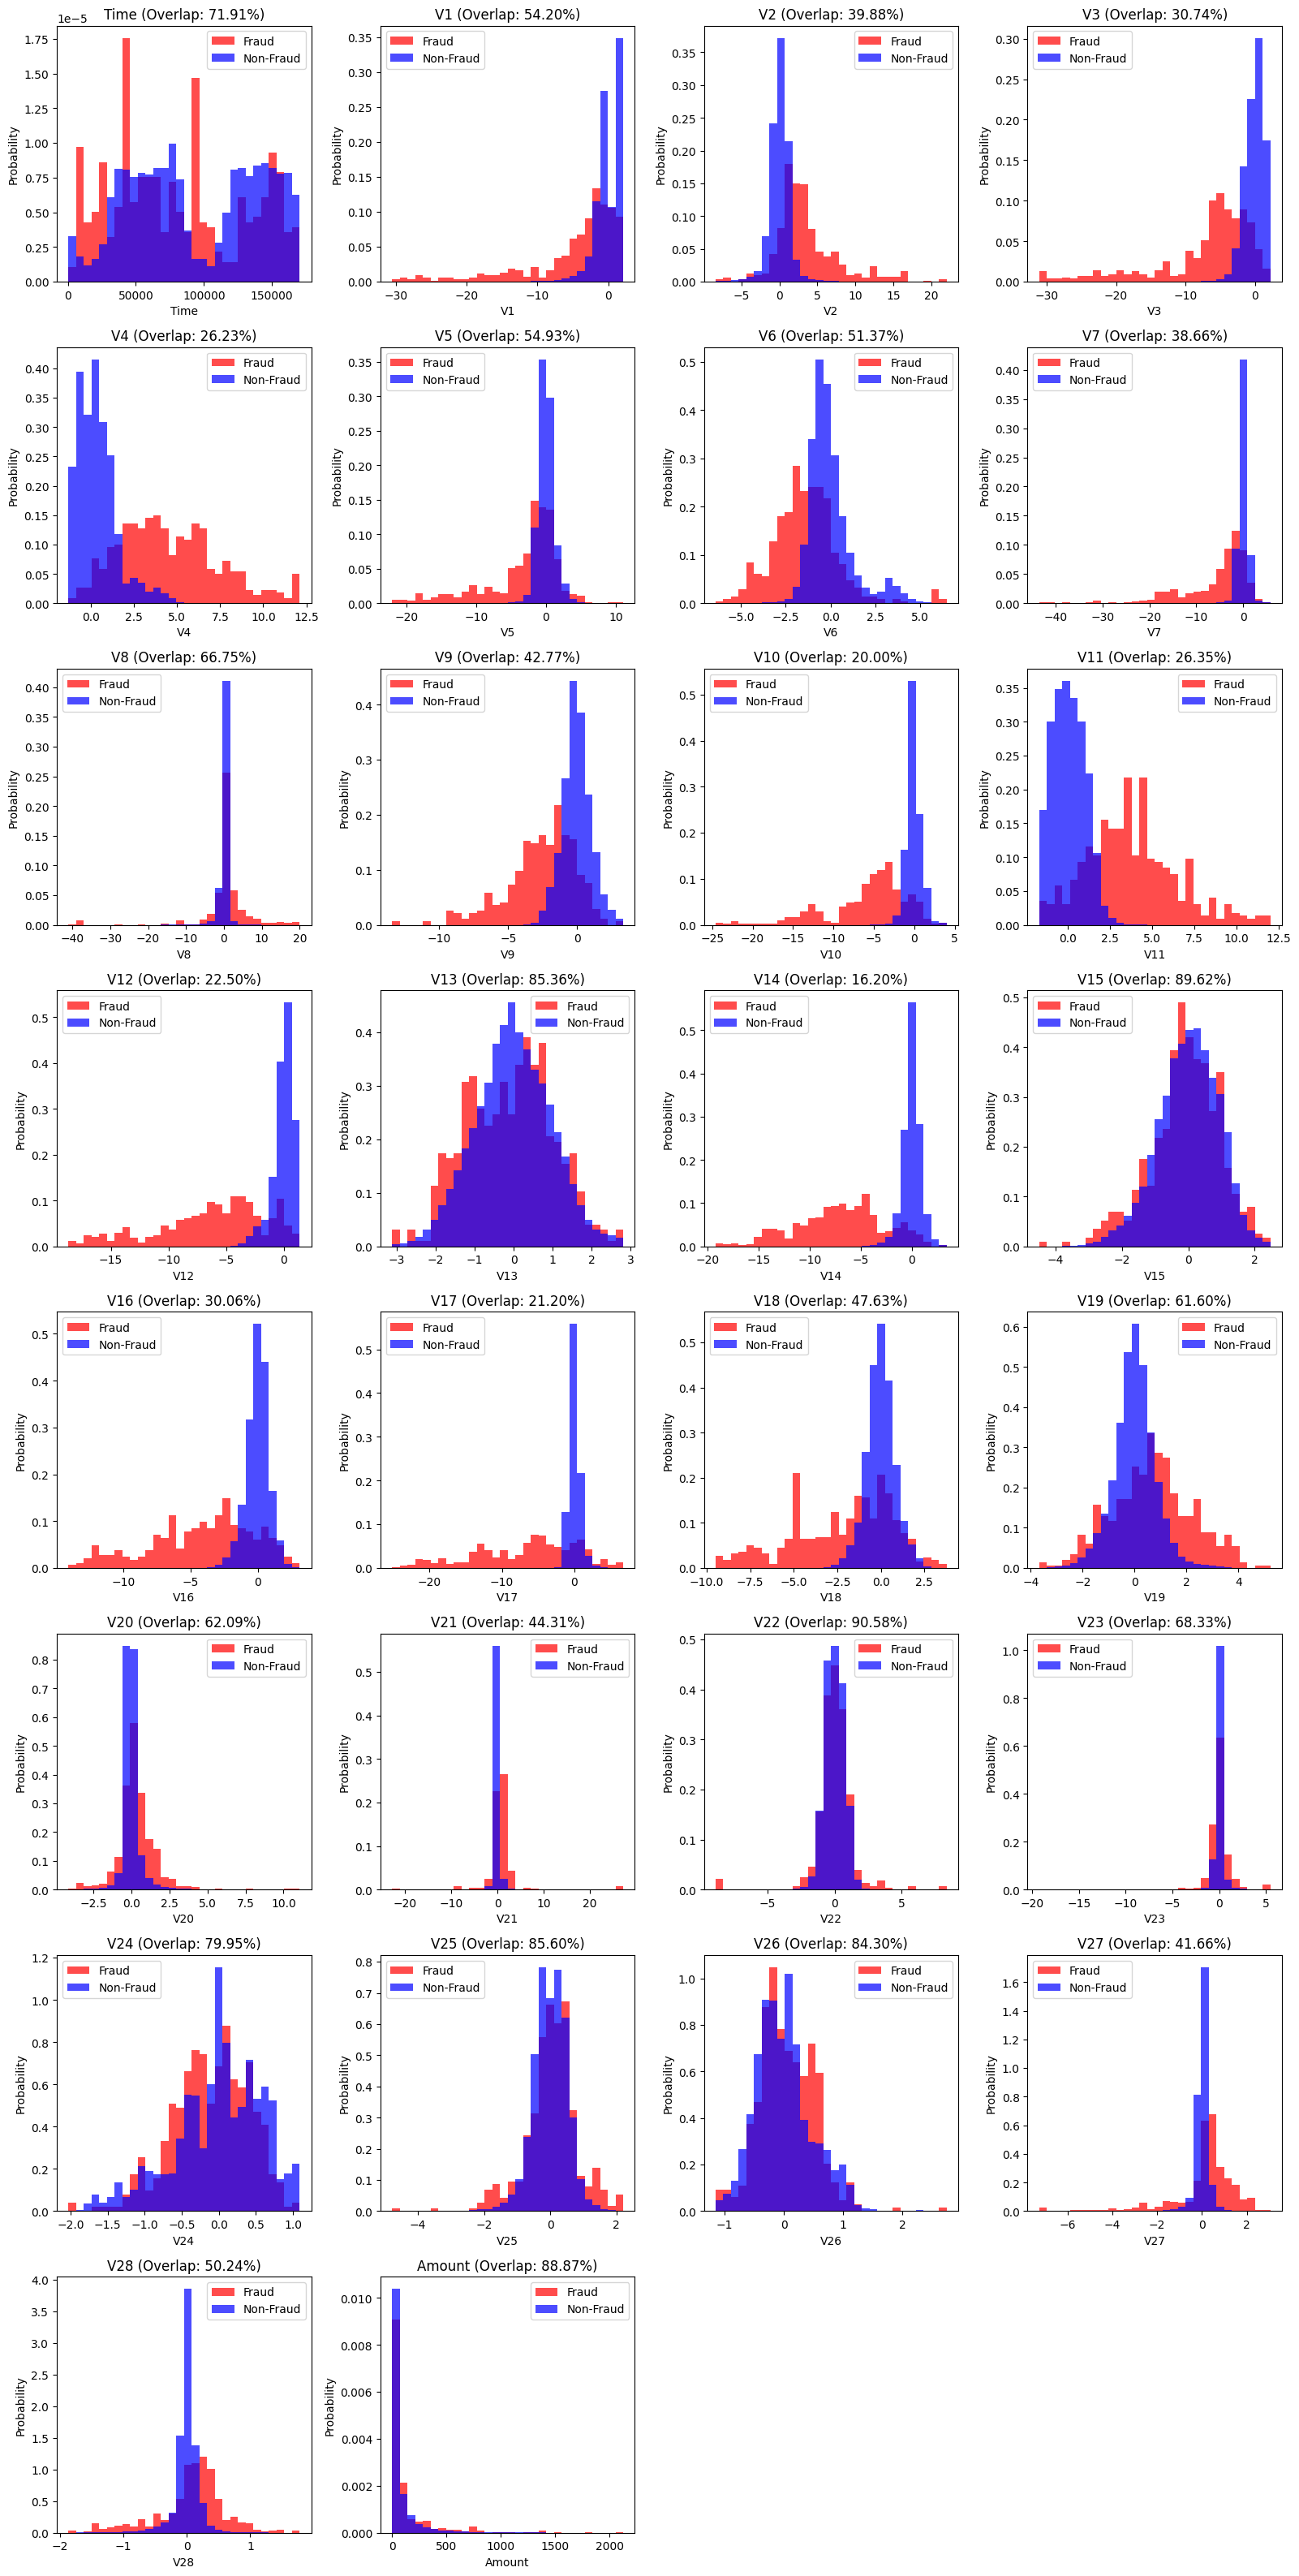

In [3]:
# Plotting a histogram for each label (fraud and non-fraud)
# To facilitate data analysis for the effect of features on the label
import numpy as np
import matplotlib.pyplot as plt

# Function to calculate percentage overlap
def calculate_overlap(hist1, hist2, bin_widths):
    # Multiply the minimum values by bin widths to account for probability density
    overlap_area = np.sum(np.minimum(hist1, hist2) * bin_widths)
    return overlap_area * 100  # Convert to percentage

# Plotting histograms with percentage overlaps
num_cols = len(df.columns) -1 # Get number of columns except the Class label
num_rows = (num_cols + 3) // 4  # Calculate rows to fit in 4 column grid

plt.figure(figsize=(16, 4*num_rows))  # Adjust figure height for calculated rows


for i, label in enumerate(df.columns[:-1], 1):  # Exclude the 'Class' column
    plt.subplot(num_rows, 4, i)

    # Create histograms for fraud and non-fraud
    fraud_data, bins = np.histogram(df[df["Class"] == 1][label], bins=30, density=True)
    non_fraud_data, _ = np.histogram(df[df["Class"] == 0][label], bins=bins, density=True)

    # Calculate bin widths
    bin_widths = np.diff(bins)

    # Calculate overlap
    overlap_percentage = calculate_overlap(fraud_data, non_fraud_data, bin_widths)

    # Plot histograms
    plt.hist(df[df["Class"] == 1][label], bins=bins, color="red", alpha=0.7, density=True, label="Fraud")
    plt.hist(df[df["Class"] == 0][label], bins=bins, color="blue", alpha=0.7, density=True, label="Non-Fraud")

    # Add title with percentage overlap
    plt.title(f"{label} (Overlap: {overlap_percentage:.2f}%)")
    plt.ylabel("Probability")
    plt.xlabel(label)
    plt.legend()

plt.tight_layout()
plt.show()



### Analyzing Overlap for Feature Selection

**Note**: The overlap percentage displayed on top of each histogram shows the percentage by which the two classes overlap for that given feature. A lower percentage overlap indicates a greater divide between the two classes given a classification based on that feature.

**The aim here is to look for the following categories of features:**
- Features with an overlap of over 60% would indicate low discriminative power and would therefore be dopped.
- Features with an overlap under 40% would indicate high discriminative power and would therefore be retained.
- Features with an overlap in the middle range of 40-60% would require further analysis in order to determine whether they should be dropped or retained.

**Observing the results:**

Features with an overlap of 40% or below are (To Be Retained):
- V2 (39.88%)
- V3 (30.74%)
- V11 (26.35%)
- V12 (22.50%)
- V14 (16.20%)
- V16 (30.06%)
- V17 (21.20%)
- V27 (41.66%)


Features with an overlap above 60% (To Be Dropped):
- V8 (66.75%)
- V15 (89.62%)
- V21 (90.58%)
- V22 (85.60%)
- V24 (79.95%)
- V25 (85.60%)
- V26 (84.30%)

Features with an overlap of 40-60%, needing further analysis (Using Random Forest):
- V1 (54.20%)
- V6 (51.37%)
- V9 (42.77%)
- V28 (50.24%)



## Random Forest Feature Importance (Further Feature Analysis)
Further analysis for the features V1, V6, V9, V28

(Features found to have an overlap percentage in the mid range of 40-60%)

Feature Importances:
 V9     0.352042
V6     0.249331
V1     0.230481
V28    0.168147
dtype: float64


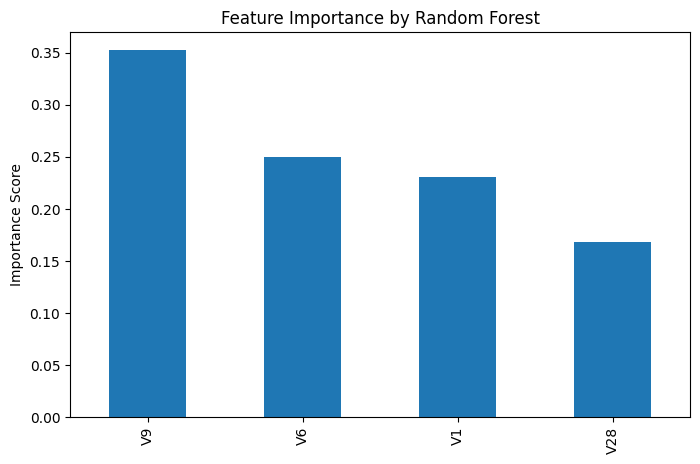

In [4]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import matplotlib.pyplot as plt

# Specify the features and target
X = df[['V1', 'V6', 'V9', 'V28']]
y = df['Class']

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf.fit(X, y)

# Get feature importances
feature_importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Print and visualize feature importances
print("Feature Importances:\n", feature_importances)

# Plot feature importances
feature_importances.plot(kind='bar', figsize=(8, 5), title="Feature Importance by Random Forest")
plt.ylabel("Importance Score")
plt.show()


Based on these results, with each feature scoring an importance score of > 0.1, all these features would be retained.


**-> Derived Actionable: Drop Features V8, V15, V21, V22, V24, V25, V26**

---


## **Outlier Detection and Handling (For Time and Amount Column)**


## Box Plots & Interquartile Method for Outlier Detection

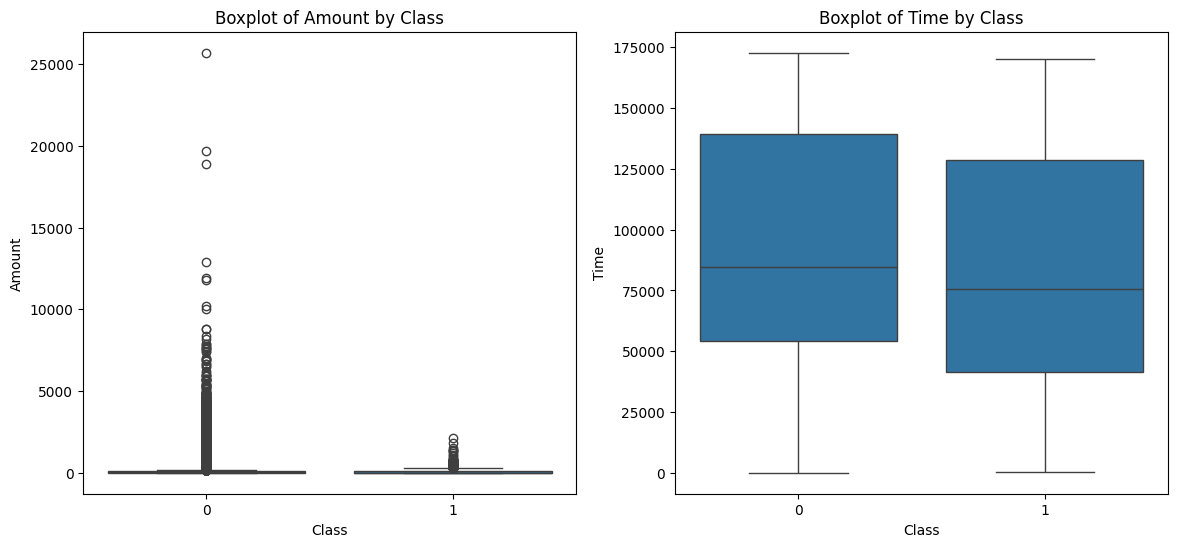

In [5]:
import seaborn as sns

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.boxplot(x='Class', y='Amount', data=df)
plt.title("Boxplot of Amount by Class")

plt.subplot(1, 2, 2)
sns.boxplot(x='Class', y='Time', data=df)
plt.title("Boxplot of Time by Class")
plt.show()

The above boxplot shows a large number of outliers in the Amount Column for both classes. This could also be discerned from observing the Amount column's histogram which was highly skewed.


**-> Derived Actionable: Apply log transformation to Amount Column (After that the Amount column is Normalized).**


### Interquartile Method (IQR) For Outlier Detection

In [6]:
# Detect and handle outliers using IQR
for column in ['Amount', 'Time']:  # Analyze 'Amount' and 'Time'
  Q1 = df[column].quantile(0.25)
  Q3 = df[column].quantile(0.75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  # Define the 'outliers' variable for the current column
  outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]

  # Check fraud cases among outliers
  fraud_outliers = outliers[outliers['Class'] == 1]
  print(f"Outliers in {column}: {len(outliers)}")
  print(f"Fraud cases among outliers in {column}: {len(fraud_outliers)}")

  # Optionally cap outliers
  #df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)



Outliers in Amount: 31904
Fraud cases among outliers in Amount: 91
Outliers in Time: 0
Fraud cases among outliers in Time: 0


This output shows 31904 rows flagged as outliers in the Amount column based on the IQR method.

These outliers are transactions with amounts significantly higher than most other transactions (e.g. exceeding the upper whisker in the boxplot above)


For the time column, there is not outlier-specific action needed.

## Visualizing the Class Imbalance

Percentage of Fraud (Class==1): 99.82725143693798%
Percentage of Non-Fraud (Class==0): 0.1727485630620034%


<ipython-input-7-82357388f4e6>:2: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  class_num = pd.value_counts(df["Class"], sort=True)


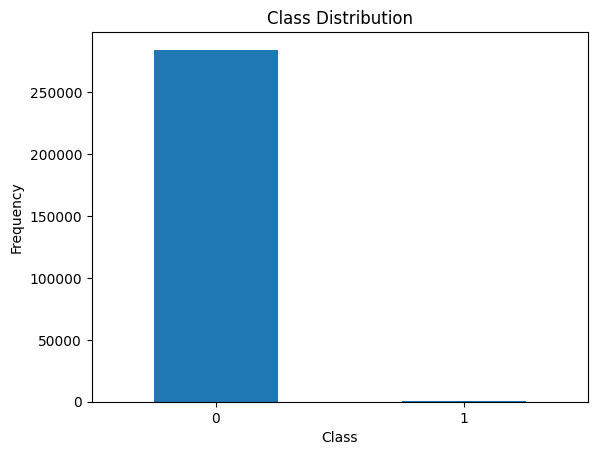

In [7]:
# Visualizing the split between fraud and non-fraud class
class_num = pd.value_counts(df["Class"], sort=True)
class_num.plot(kind="bar", rot=0)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

# Checking the percentage of fraud and non-fraud instances
print(f"Percentage of Fraud (Class==1): {df['Class'].value_counts()[0]/len(df) * 100}%")
print(f"Percentage of Non-Fraud (Class==0): {df['Class'].value_counts()[1]/len(df) * 100}%")

The bar chart above shows that fraud class accounts for 492 cases out of the total 284,807 transactions (Indicating a major class imbalance)

Only 0.173% of the dataset contains cases of fraud, while 99.827% is not fraud (values may vary to a few d.p). This means the dataset is heavily skewed/imbalanced and that will need to be dealt with.

**-> Derived Actionable: Oversample the Fraud class and/or undersample the Non-fraud class. Possibly use SMOTE.**

In [8]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


As can be seen from this sample of the dataset, columns V1 to V28 have been scaled, the only expceptions of scaling being the Time column and the Amount column.

**-> Derived Actionable: Scale the Time and Amount columns appropriately, either via Standardization or Normalization**

## Summary Statistics Between Fraud and Non-Fraud

Comparing summary statistics between fraud (Class=1) and non-fraud transactions (Class=0) for Time and Amount to detect any distinct patterns that could aid classification

In [9]:
fraud_data = df[df['Class'] == 1]
non_fraud_data = df[df['Class'] == 0]
print("Fraud Amount Summary:\n", fraud_data['Amount'].describe())
print("----------------------")
print("Non-Fraud Amount Summary:\n", non_fraud_data['Amount'].describe())
print("----------------------")
print("Fraud Time Summary:\n", fraud_data['Time'].describe())
print("----------------------")
print("Non-Fraud Time Summary:\n", non_fraud_data['Time'].describe())

Fraud Amount Summary:
 count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64
----------------------
Non-Fraud Amount Summary:
 count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64
----------------------
Fraud Time Summary:
 count       492.000000
mean      80746.806911
std       47835.365138
min         406.000000
25%       41241.500000
50%       75568.500000
75%      128483.000000
max      170348.000000
Name: Time, dtype: float64
----------------------
Non-Fraud Time Summary:
 count    284315.000000
mean      94838.202258
std       47484.015786
min           0.000000
25%       54230.000000
50%       84711.000000
75%      139333.000000
max      172792.000000
Name: Time, dtype: float64


Amount Column:

* Both fraudulent and non-fraudulent transactions have similar levels of variability in terms of transactions amount.

* The mean and quartile differences are much more pronounced than variability in the standard deviation.


Time Column:

* There seems to be no clear pattern that indicates time of day strongly distinguishes frauyd from non-fraud.

* This idea is further supported by the the overlap of 71.9% that can be seen in the histogram for the Time column between the Fraud and Non-Fraud classes.

* This means the Time feature may not be a useful feature in its current state and can benefit from normalization or binning.??

## Transaction Amount Analysis

Exploring if there are distinct patterns in Amount for fraud and non-fraud transactions by visualizing and calculating summary statistics.

For example, fraud might occur more often with lower or higher amounts.




<ipython-input-10-387f79afd2f6>:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(fraud_data['Amount'], label="Fraud", shade=True)
<ipython-input-10-387f79afd2f6>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(non_fraud_data['Amount'], label="Non-Fraud", shade=True)


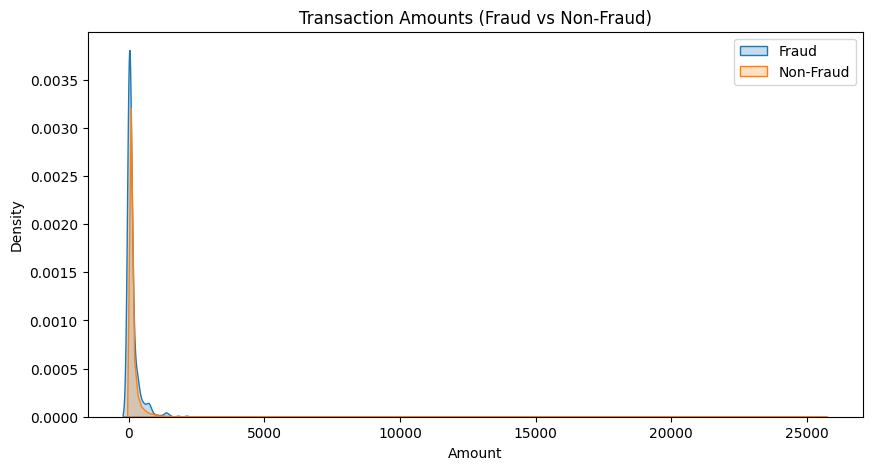

In [10]:
plt.figure(figsize=(10, 5))
sns.kdeplot(fraud_data['Amount'], label="Fraud", shade=True)
sns.kdeplot(non_fraud_data['Amount'], label="Non-Fraud", shade=True)
plt.title("Transaction Amounts (Fraud vs Non-Fraud)")
plt.xlabel("Amount")
plt.legend()
plt.show()

*  Both Fraud and Non-fraud transaction amounts are heavily skewed toward smaller values.

* Fraud transactions (blue line) appear concentrated around lower values (close to 0), while Non-Fraud transactions (orange line) has a broader spread into larger amounts but still concentrated near 0.

  *  There are extreme values, especially for Non-Fraud transactions, where the curve extends towards 25,000.

* There is significant overlap between Fraud and Non-Fraud classes at lower transaction amounts, which aligns with the summary statistics and earlier histogram analysis.

## Explained Variance Analysis for PCA Transformed Features

Since the features V1 to V28 are already PCA-transformed and the explained variance ratios were not saved or provided during the PCA process, there is no direct way to calculate the explained variance because the original PCA model and data are not available.

The alternatives such as measuring feature importance of the fraud and non-fraud overlap for each feature were measured above to compensate for the lack of analysis on explained variance.



## Summing Up Actionable Steps for Data Preprocessing

### Actionable Steps for Data Preprocessing (Ordered)

*  **Actionable Step 1:** Drop Features V8, V15, V21, V22, V24, V25, V26 **(Feature Selection)**

*  *Intermediate Step: Split dataset into Train, Validation & Test Sets.*

*  **Actionable Step 2:** Apply log transformation to Amount Column **(Outlier Handling)**

*  **Actionable Step 3**: Normalize the Amount and Time column **(Scaling Features for consistent ranges)**

*  **Actionable Step 4:** Oversample the Fraud class and/or undersample the Non-fraud class. Possible use SMOTE.

Questions:

1. Do all of these data preprocessing steps only apply to the training set or does it at some point apply to the other sets (test and validation) and if it does, when?

2. What is the difference between standardization and normalization and which one is more applicble for PCA transformed for the Amount column (Given other features are PCA transformed)?

3.

---

# Data Preprocessing

In this step we will apply the data preprocessing actionable steps derived from our data analysis above.

### Actionable Step 1 - Drop Irrelvant Features (V8, V15, V21, V22, V24, V25, V26)

In [11]:
# Drop irrelevant features
df = df.drop(columns=['V8', 'V15', 'V21', 'V22', 'V24', 'V25', 'V26'])

### Actionable Step #2 - Splitting Dataset into training, validation and test sets

In [12]:
# Splitting data set into training, validation and testing
# 0-70%: Training
# 70-100% of Dataset: Testing
training_set, testing_set = np.split(df.sample(frac=1, random_state=42), [int(0.7 * len(df))])


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


### Actionable Step #3 - Log Transform the Amount Column


In [13]:
# Log transformation for Amount column
for subset in [training_set, testing_set]:
    subset['Amount'] = np.log1p(subset['Amount'])  # Use log1p to handle zeros safely


#**K-Fold Cross Validation & Hyper Parameter Tuning**

K-Fold Cross Validation is performed at this stage as the first 3 preprocessing steps preceding it are:

- Dropping Irrelevant Features
- Creating the Train-Test Split
- Log Transformations of the Amount Column


K-Fold CV has to take place before the training set undergoes Normalization and SMOTE, as these preprocessing steps need to take place inside the cross-validation loop. This is such that each fold's training portion has its own preprocessing applied without knowledge of the validation portion.



## Setting up the Train and Test Sets for K-Fold Cross Validation



In [14]:
# Define features/targets (DO NOT SCALE OR OVERSAMPLE YET)
X_train = training_set.drop(columns=['Class'])
y_train = training_set['Class']
X_test = testing_set.drop(columns=['Class'])
y_test = testing_set['Class']

## Imports Needed


In [18]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, make_scorer, precision_score, recall_score, f1_score
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from sklearn.compose import ColumnTransformer

## 1. Defining Hyper-Parameters for each Model

This defines the search space for hyper-parameter tuning for each learning model.

- Naive Bayes has no tunable hyper-parameters, so we leave it as an empty dictionary.

- Logistic Regression: We tune:
  - *c:* which controls regularization strength
  - *max-iter*: which defines the maximum number of iterations for convergence.

- Random Forest: We tune multiple parameters such as:
  - *n_estimators:* The number of trees in the forest
  - *max-depth:* The maximum depth of each tree
  - *min_samples_leaf:* The minimum number of samples required in a leaf node.

- Support Vector Machines (SVM): We tune:
  - *c:* Controls regularization
  - *kernel:* Specifies the kernel type (linear or RBF)
  - *gamma:* Controls the influence of a single training example.

In [16]:
# Define Hyper-parameter Grids for Each Model
param_grids = {
    "Naive Bayes": {},  # No hyper-parameters to tune for GaussianNB
    "Logistic Regression": {
        "classifier__C": [0.01, 0.1, 1, 10],  # Regularization strength
        "classifier__max_iter": [100, 500, 1000]
    },
    "Random Forest": {
        "classifier__n_estimators": [50, 100, 150],  # Number of trees
        "classifier__max_depth": [10, 20, 30, None],
        "classifier__min_samples_split": [2, 5, 10],
        "classifier__min_samples_leaf": [1, 2, 4]
    },
    "Support Vector Machines": {
        "classifier__C": [0.1, 1, 10, 100],  # Regularization parameter
        "classifier__kernel": ["linear", "rbf"],
        "classifier__gamma": ["scale", "auto"]
    }
}

## 2. Defining the Models and Scoring Metrics

This initializes the models that will be trained and tested.

- GaussianNB(): Naive Bayes classifier (no hyper-parameters to tune).
- LogisticRegression(): Includes class_weight='balanced' to handle class imbalance.
- RandomForestClassifier: Uses class_weight='balanced' to account for fraud cases.

Here as well, evaluation metrics for model performance are defined:

- Precision: Measures how many predicted fraud cases are actually fraud.
- Recall: Measures how many actual fraud cases were corretly detected.
- F1-score: Balances precision and recall.

In [19]:
models = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Support Vector Machines": SVC(kernel='linear', class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42)
}

# Define Scoring Metrics for GridSearchCV
scoring = {
    "Precision": make_scorer(precision_score, pos_label=1),
    "Recall": make_scorer(recall_score, pos_label=1),
    "F1-Score": make_scorer(f1_score, pos_label=1),
}

## 3. Defining Pipelines for Each Model

- ColumnTransformer ensures that only the "Amount" and "Time" columns are standardized, leaving PCA-transforme features unchanges.

- Pipeline are defined to steamline training:
  - scaler: Standardizes "Amount" and "Time"
  - smote: Applies SMOTE inside cross-validation to balanmce fraud and non-fraud cases.
  - classifier: The machine learning model itself.

- Stratified K-Fold: is used for cross-validation to ensure each fold maintains the class imbalance distribution.

In [20]:
scaler = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['Amount', 'Time'])  # Scale only 'Amount' and 'Time'
    ], remainder='passthrough'  # Keep PCA features unchanged
)

# Define Pipelines for Each Model
pipelines = {}
for model_name, model in models.items():
    pipelines[model_name] = ImbPipeline([
        ("scaler", scaler),  # Scale 'Amount' and 'Time' only
        ("smote", SMOTE(random_state=42)),  # Apply SMOTE only to training folds
        ("classifier", model)  # The model
    ])

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

## 4. Performing Hyper-Parameter Tuning using GridSearchCV

Here GridSearchCV is used for Hyper-parameter tuning to find the best parameters for each model.

- If a model has hyper-parameters to tune, GridSearchCV will:

  - Test all hyper-parameter combinations
  - Train and evaluate each combination using 5-Fold Stratified Cross Validation.
  - Select the best performing combination based on F1-score.

- If a model doesn't have hyper-parameters (e.g. Naive Bayes), it is trained directly without tuning.

- After tuning, the best models are evaluated on the test set, and results are diplayed using a classification report.


In [ ]:
best_models = {}
best_params = {}

for model_name, pipeline in pipelines.items():
    print(f"Running GridSearchCV for {model_name}...\n")

    # If model has hyper-parameters to tune, perform GridSearchCV
    if param_grids[model_name]:
        grid_search = GridSearchCV(
            pipeline,
            param_grids[model_name],
            cv=kf,
            scoring="f1",  # Using F1-score as the primary metric
            n_jobs=-1,
            verbose=1  # Show progress
        )
        grid_search.fit(X_train, y_train)  # Fit the pipeline on the training set
        best_models[model_name] = grid_search.best_estimator_
        best_params[model_name] = grid_search.best_params_

        print(f"Best Parameters for {model_name}: {grid_search.best_params_}\n")
    else:
        # If model has no hyper-parameters to tune (e.g., Naive Bayes)
        best_models[model_name] = pipeline.fit(X_train, y_train)

# --- Final Model Training & Testing on Best Parameters ---
print("\n--- Final Model Evaluation on Test Set ---")
from sklearn.metrics import classification_report

for model_name, best_model in best_models.items():
    y_pred = best_model.predict(X_test)  # Predict on test set

    print(f"\n{model_name} Performance on Test Set:")
    print(classification_report(y_test, y_pred))

Running GridSearchCV for Naive Bayes...

Running GridSearchCV for Logistic Regression...

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for Logistic Regression: {'classifier__C': 0.1, 'classifier__max_iter': 100}

Running GridSearchCV for Support Vector Machines...

Fitting 5 folds for each of 16 candidates, totalling 80 fits


### Actionable Step #4 - Normalize the Amount and Time Column

still not sure whether to normalize or standardize

In [ ]:
# Normalize the Amount and Time Column
from sklearn.preprocessing import StandardScaler

# Initialize scaler
scaler = StandardScaler()

# Fit scaler on training set and transform all subsets
training_set[['Amount', 'Time']] = scaler.fit_transform(training_set[['Amount', 'Time']])
# validation_set[['Amount', 'Time']] = scaler.transform(validation_set[['Amount', 'Time']])
testing_set[['Amount', 'Time']] = scaler.transform(testing_set[['Amount', 'Time']])

### Actionable Step #5 - Balance Training Set using SMOTE

In [ ]:
# Applying SMOTE to the training set
from imblearn.over_sampling import SMOTE

# Separate features and target in the training set
X_train = training_set.drop(columns=['Class'])
y_train = training_set['Class']

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Recombine balanced data
training_set_balanced = pd.concat([pd.DataFrame(X_train_balanced, columns=X_train.columns),
                                   pd.DataFrame(y_train_balanced, columns=['Class'])], axis=1)

Defining a function to scale (Using Standard Scaler for now) the Time and Amount columns for a given dataset.

We only scale those two columns as the rest of the features in the dataset (Features V1 to V28) are already scaled.

Checking the number of 0 and 1 classes after applying SMOTE (Synthetic Minority Oversampling Technique) Oversampler

In [ ]:
sum(y_train_balanced == 0)

In [ ]:
sum(y_train_balanced == 1)

As we can see above, the number of 0 and 1 classes in the training dataset is equal

### Defining Training and Testing Features and Target

In [ ]:
# 1. Separate features and target for the balanced training set
X_train = training_set_balanced.drop(columns=['Class'])
y_train = training_set_balanced['Class']

# 2. Prepare test set (features and target)
X_test = testing_set.drop(columns=['Class'])
y_test = testing_set['Class']

# Verify dimensions
print(f"Training set: X_train shape = {X_train.shape}, y_train shape = {y_train.shape}")
print(f"Testing set: X_test shape = {X_test.shape}, y_test shape = {y_test.shape}")


# K-Fold Cross Validation

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

# Defining the models
models = {
  "Naive Bayes": BernoulliNB(),
  "Logistic Regression": LogisticRegression(class_weight='balanced', penalty='l2'),
  "Random Forest": RandomForestClassifier(class_weight='balanced', random_state=42),
  "Support Vector Machines": SVC(kernel='rbf', class_weight="balanced")
}

# Defining the evaluation metrics
scoring = {
  "Precision": make_scorer(precision_score, pos_label=1),
  "Recall": make_scorer(recall_score, pos_label=1),
  "F1-Score": make_scorer(f1_score, pos_label=1),
}

# Initialize Stratified K-Fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Looping through the models
for model_name, model in models.items():
  print(f"Evaluating {model_name} using 5-Fold Cross Validation")
  for metric_name, scorer in scoring.items():
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring=scorer)
    print(f"{metric_name}: Mean = {np.mean(scores):.4f}, Std = {np.std(scores):.4f}")
  print("-" * 50)


## Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import classification_report

# 1. Train Naive Bayes model
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)

# 2. Predict on the test set
y_pred = nb_model.predict(X_test)

# 3. Evaluate the model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Non-fraud", "Fraud"]))


## Logistic Regression


In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(class_weight='balanced', penalty='l2')
lr_model.fit(X_train, y_train)

In [ ]:
y_pred = lr_model.predict(X_test)
print(classification_report(y_test, y_pred))

## Random Forest


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

In [ ]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

## Support Vector Machines

In [ ]:
from sklearn.svm import SVC

svc_model = SVC(kernel='rbf', class_weight="balanced")
svc_model.fit(X_train, y_train)

In [ ]:
y_pred = svc_model.predict(X_test)
print(classification_report(y_test, y_pred))